In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
import matplotlib.pyplot as plt
import os

# Ising model optimization

### The model

Description

$H(t) = - J \sum_j \sigma_j^z \sigma_{j+1}^z \; - g \sum_j \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_j \sigma_j^x \;$

## dCRAB Optimization

### Define the Model

In [3]:
import numpy as np
from quocslib.optimalcontrolproblems.su2 import *
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
import functools


class IsingModel(AbstractFoM):
    """A figure of merit class for optimization of the problem defined by Alastair Marshall via
    https://arxiv.org/abs/2110.06187"""
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)
        self.n_slices = args_dict.setdefault("n_slices", 100)

        self.H_drift = get_static_hamiltonian(self.n_qubits, self.J, self.g)
        self.H_control = get_control_hamiltonian(self.n_qubits)
        self.rho_0 = get_initial_state(self.n_qubits)
        self.rho_target = get_target_state(self.n_qubits)
        self.rho_final = np.zeros_like(self.rho_target)
        # allocate memory for the list containing the propagators
        self.prop_store = [np.zeros_like(self.H_drift) for _ in range(self.n_slices)]
        # Check if the propagators are already computed
        self.propagators_are_computed = False

    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift

    def get_target_state(self):
        return self.rho_target

    def get_initial_state(self):
        return self.rho_0

    def get_propagator(
        self,
        pulses_list: list = [],
        time_grids_list: list = [],
        parameters_list: list = [],
    ) -> np.array:
        """ Compute and return the list of propagators """
        drive = pulses_list[0].reshape(1, len(pulses_list[0]))
        n_slices = self.n_slices
        time_grid = time_grids_list[0]
        # dt = time_grid[1] - time_grid[0]
        dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        self.prop_store = pw_evolution(self.prop_store, drive, self.H_drift, [self.H_control], n_slices, dt)
        self.propagators_are_computed = True
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """ """
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
        U_final = functools.reduce(lambda a, b: a @ b, self.prop_store)
        # evolve initial state
        rho_final = U_final @ self.rho_0 @ U_final.T.conj()
        # Calculate the fidelity
        fidelity = fidelity_funct(rho_final.T, self.rho_target)
        return {"FoM": -fidelity}


### Define the Configuration dictionary

#### Name

In [4]:
optimization_dictionary = {"optimization_client_name": "IsingModeldCRAB"}

#### The algorithm

The name

In [5]:
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}

Settings for dCRAB: The super-iterations number and iterations

In [6]:
optimization_dictionary["algorithm_settings"]["super_iteration_number"]= 3 
optimization_dictionary["algorithm_settings"]["max_eval_total"]= 800

#### Updating algorithm and Stopping criteria

In [7]:
dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-2,
            "frtol": 1e-2
        }
    }

In [8]:
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

#### The Controls

In [9]:
pulse_x = { "pulse_name": "Pulse_1",
            "upper_limit": 100.0,
            "lower_limit": -100.0,
            "bins_number": 100,
            "amplitude_variation": 30.0,
            "time_name": "time_1"
            }

#### Initial guess

In [10]:
pulse_x["initial_guess"] = {
                "function_type": "lambda_function",
                "lambda_function": "lambda t: 0.0 + 0.0*t"
            }

#### Scaling Function


In [11]:
pulse_x["scaling_function"] = {
                "function_type": "lambda_function",
                "lambda_function": "lambda t: 1.0 + 0.0*t"
            }

### The basis

In [12]:
pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 5.0
                }
            }

#### The times

In [13]:
pulse_x["time_name"] = "time1"

In [14]:
time1 = {"time_name": "time1",
        "initial_value": 1.0 }

Insert the controls in the optimization dictionary

In [15]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

### Create the optimizer and run the optimization

In [16]:
from quocslib.Optimizer import Optimizer
import time
# Define Optimizer
optimization_obj = Optimizer(optimization_dictionary, IsingModel())
print("The optimization initialized successfully")

INFO     oc_logger    The optimization direction is minimization
The optimization initialized successfully


In [17]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.27
INFO     oc_logger    Direct search start time has been reset.
INFO     oc_logger    New record achieved. Previous FoM: 10000000000.0, new best FoM : -0.0
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: -0.0
INFO     oc_logger    New record achieved. Previous FoM: -0.0, new best FoM : -0.0437573648041992
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: -0.0437573648041992
INFO     oc_logger    New record achieved. Previous FoM: -0.0437573648041992, new best FoM : -0.1827519726174643
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: -0.1827519726174643
INFO     oc_logger    New record achieved. Previous FoM: -0.1827519726174643, new best FoM : -0.3778924083992416
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: -0.3778924083992416
INFO     oc_logger    Function evaluation num

INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 25, FoM: -0.7503800198712283
INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 25, FoM: -0.9078999840664024
INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 26, FoM: -0.7541004384103421
INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 26, FoM: -0.918234567553565
INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 27, FoM: -0.8776404444194024
INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 28, FoM: -0.9060029356594129
INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 29, FoM: -0.8825235675236838
INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 30, FoM: -0.6573635273341335
INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 30, FoM: -0.9601141426

INFO     oc_logger    Function evaluation number: 137, SI: 2, Sub-iteration number: 8, FoM: -0.8561134019501431
INFO     oc_logger    Function evaluation number: 138, SI: 2, Sub-iteration number: 8, FoM: -0.43465493517661985
INFO     oc_logger    Function evaluation number: 139, SI: 2, Sub-iteration number: 8, FoM: -0.6408735247116544
INFO     oc_logger    Function evaluation number: 140, SI: 2, Sub-iteration number: 8, FoM: -0.43135856276770385
INFO     oc_logger    Function evaluation number: 141, SI: 2, Sub-iteration number: 8, FoM: -0.7263298083897869
INFO     oc_logger    Function evaluation number: 142, SI: 2, Sub-iteration number: 8, FoM: -0.3835310762271247
INFO     oc_logger    Function evaluation number: 143, SI: 2, Sub-iteration number: 8, FoM: -0.7925048510705512
INFO     oc_logger    Function evaluation number: 144, SI: 2, Sub-iteration number: 8, FoM: -0.5585825734520475
INFO     oc_logger    Function evaluation number: 145, SI: 2, Sub-iteration number: 8, FoM: -0.1981509

INFO     oc_logger    Function evaluation number: 210, SI: 2, Sub-iteration number: 41, FoM: -0.9787102831620489
INFO     oc_logger    Function evaluation number: 211, SI: 2, Sub-iteration number: 42, FoM: -0.9740117172512817
INFO     oc_logger    New record achieved. Previous FoM: -0.9838752726636226, new best FoM : -0.9847243312868831
INFO     oc_logger    Function evaluation number: 212, SI: 2, Sub-iteration number: 43, FoM: -0.9847243312868831
INFO     oc_logger    Function evaluation number: 213, SI: 2, Sub-iteration number: 43, FoM: -0.9707790228855079
INFO     oc_logger    Function evaluation number: 214, SI: 2, Sub-iteration number: 44, FoM: -0.9636526051540798
INFO     oc_logger    Function evaluation number: 215, SI: 2, Sub-iteration number: 44, FoM: -0.9828146578237629
INFO     oc_logger    Function evaluation number: 216, SI: 2, Sub-iteration number: 45, FoM: -0.9711699041425605
INFO     oc_logger    Function evaluation number: 217, SI: 2, Sub-iteration number: 45, FoM: -0.

INFO     oc_logger    Function evaluation number: 280, SI: 3, Sub-iteration number: 25, FoM: -0.8714245564383315
INFO     oc_logger    Function evaluation number: 281, SI: 3, Sub-iteration number: 26, FoM: -0.5178574017270323
INFO     oc_logger    Function evaluation number: 282, SI: 3, Sub-iteration number: 26, FoM: -0.9390781886536316
INFO     oc_logger    Function evaluation number: 283, SI: 3, Sub-iteration number: 27, FoM: -0.7395134802498153
INFO     oc_logger    Function evaluation number: 284, SI: 3, Sub-iteration number: 28, FoM: -0.6254815117506408
INFO     oc_logger    Function evaluation number: 285, SI: 3, Sub-iteration number: 28, FoM: -0.9465620741758456
INFO     oc_logger    Function evaluation number: 286, SI: 3, Sub-iteration number: 29, FoM: -0.7101220926925891
INFO     oc_logger    Function evaluation number: 287, SI: 3, Sub-iteration number: 29, FoM: -0.924631727709804
INFO     oc_logger    Function evaluation number: 288, SI: 3, Sub-iteration number: 30, FoM: -0.8

Text(0, 0.5, 'Amplitude')

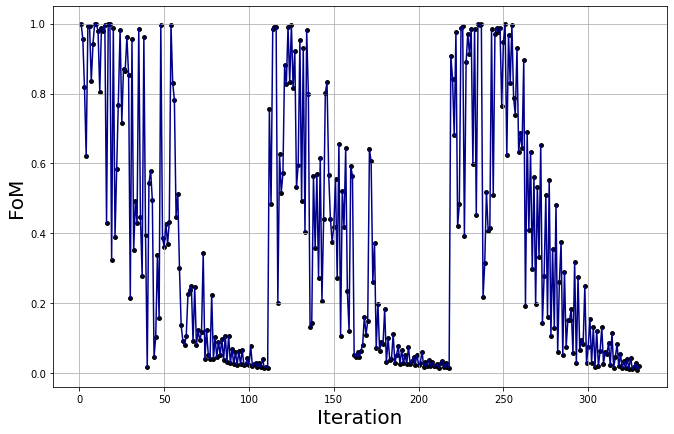

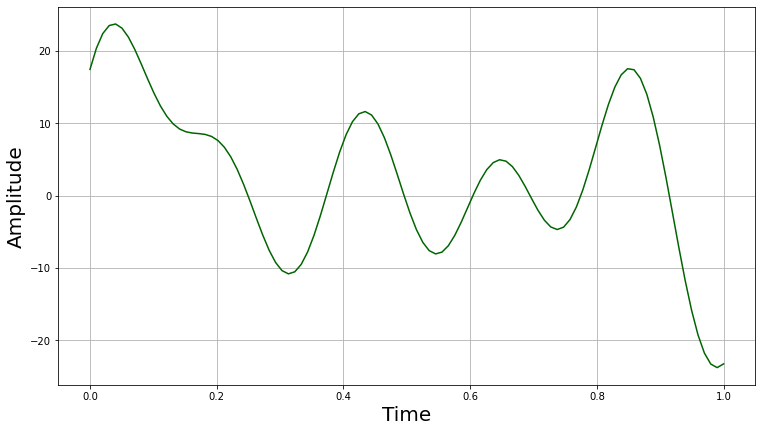

In [18]:
opt_alg_obj = optimization_obj.get_optimization_algorithm()
# FoM vs Iterations
fomlist = opt_alg_obj.FoM_list
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, 1 + np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, 1 + np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('FoM', fontsize=20)
# Controls
controls = opt_alg_obj.get_best_controls()
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.plot(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

## GRAPE optimization

In [19]:
optimization_dictionary["optimization_client_name"] = "IsingModeldGRAPE"

### The Settings

In [20]:
optimization_dictionary["algorithm_settings"] = {
        "algorithm_name": "GRAPE"
    }

### Define the basis

In [21]:
pulse_x["basis"] = {
                "basis_name": "PiecewiseBasis",
                "bins_number": 100
}

### Create the Optimizer

In [22]:
# Define Optimizer
optimization_obj = Optimizer(optimization_dictionary, IsingModel())
print("The optimization initialized successfully")

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    Random number generator from the numpy library, version 1.21.5
The optimization initialized successfully


### Run the optimization

In [23]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.27
INFO     oc_logger    New record achieved. Previous FoM: 10000000000.0, new best FoM : -0.06355104516677007
INFO     oc_logger    Function evaluation number: 1, FoM: -0.06355104516677007
INFO     oc_logger    New record achieved. Previous FoM: -0.06355104516677007, new best FoM : -0.07466711298244653
INFO     oc_logger    Function evaluation number: 2, FoM: -0.07466711298244653
INFO     oc_logger    New record achieved. Previous FoM: -0.07466711298244653, new best FoM : -0.14804285023768562
INFO     oc_logger    Function evaluation number: 3, FoM: -0.14804285023768562
INFO     oc_logger    New record achieved. Previous FoM: -0.14804285023768562, new best FoM : -0.7406942940961485
INFO     oc_logger    Function evaluation number: 4, FoM: -0.7406942940961485
INFO     oc_logger    Function evaluation number: 5, FoM: -0.0013251583520049314
INFO     oc_logger    Function evaluation number: 6, FoM: -0.7396625359575456
INFO     oc_logger    N

INFO     oc_logger    Figure of merit : -0.9990581198357122
INFO     oc_logger    nfev : 44
The optimization took 2.0839407444000244 seconds


### Read the results

Text(0, 0.5, 'Amplitude')

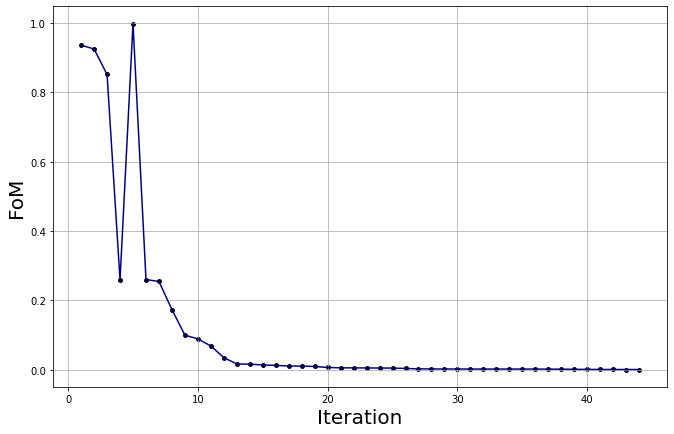

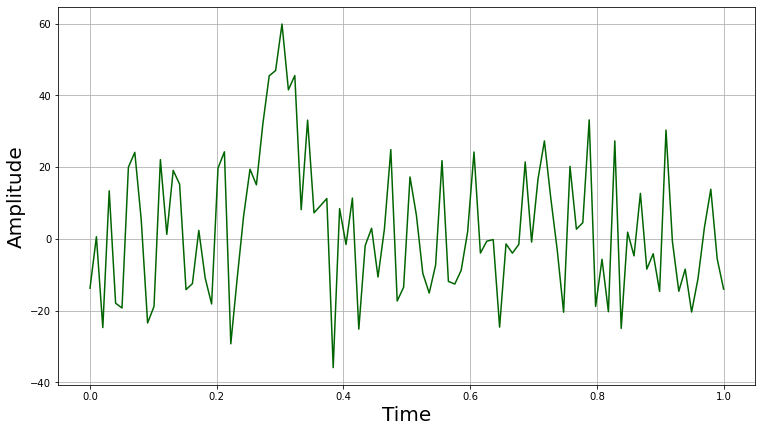

In [24]:
opt_alg_obj = optimization_obj.get_optimization_algorithm()
# FoM vs Iterations
fomlist = opt_alg_obj.FoM_list
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, 1 + np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, 1 + np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('FoM', fontsize=20)
# Controls
controls = opt_alg_obj.get_best_controls()
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.plot(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

QuOCS version

In [25]:
import quocslib
quocslib.__VERSION__

'0.0.27'